# Lesson 3: Object Detection

In [1]:
# Import necessary libraries
# Setup paths and import local libraries
import sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

# Import comet_ml for experiment tracking
import comet_ml

# To display the image
from PIL import Image
from PIL.ImageFilter import GaussianBlur

# Import necessary modules from transformers and ultralytics
from transformers import pipeline
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
import torch
from ultralytics import SAM

# To access the current working directory
if "has_changed_dir" not in globals():
    # Change directory only the first time
    %cd ..
    # Set the flag to indicate the change has been made
    has_changed_dir = True
    %ls ..
# has_changed_dir = False

prj_path = Path('Prompt-Engineering-for-Vision-Models')
sys.path.insert(0, str(prj_path))

from utils import preprocess_outputs
from utils import show_boxes_and_labels_on_image
from utils import show_masks_on_image
from utils import make_bbox_annots
from utils import resize_image
from utils import get_model

/home/sdjkhosh/miniconda3/envs/prompt/lib/python3.9/site-packages/comet_ml/env_logging.py:34: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/home/sdjkhosh/miniconda3/envs/prompt/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/sdjkhosh/Projects/Prompt-Engineering-for-Vision-Models
'Equalized Color '$'\n''Roadmap Images.png'        Stream-Assesment/
'Equalized Gray Scale '$'\n''Roadmap Images.png'   VBN_backup/
'Gray Scale '$'\n''Roadmap Images.png'             msfs2020-map-enhancement/
 Memphis_wrong/                                    terrAInav-Mapper/
 Prompt-Engineering-for-Vision-Models/             terrAInav-Sim/
 SkyAI/


### Import and prepare the models
#### SAM Model


In [2]:
# documentation: https://docs.ultralytics.com/models/sam-2/#how-to-use-sam-2-versatility-in-image-and-video-segmentation
versions = ['mobile_sam', 'sam_b', 'sam_l', 'sam2.1_b', 'sam2_b', 'sam2.1_s', 'sam2_s', 'sam2.1_l', 'sam2_l', 'sam2.1_t', 'sam2_t']
SAM_version = versions[3]  # Change this to the desired version
model = SAM(model=get_model(SAM_version))  # Specify the model path directly
model.info()  # Display model information (optional)

# Run inference (image or video)
#results = model("https://ultralytics.com/images/bus.jpg")  # image
# results = model("https://youtu.be/LNwODJXcvt4")  # video file

#results[0].show()  # Display results

Model summary: 403 layers, 80,850,178 parameters, 80,850,178 gradients


(403, 80850178, 80850178, 0.0)

#### Detector Model

In [3]:
# Info about ['google/owlvit-base-patch32'](https://huggingface.co/google/owlvit-base-patch32)

OWL_checkpoint = 'google/owlvit-base-patch32'
Dino_checkpoint = 'IDEA-Research/grounding-dino-base'
obj_det_model = Dino_checkpoint

detector = pipeline("zero-shot-object-detection", model=obj_det_model)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/home/sdjkhosh/miniconda3/envs/prompt/lib/python3.9/site-packages/torch/cuda/__init__.py:174: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
Device set to use cpu


### Load comet_ml logger

In [4]:
comet_ml.login(anonymous=True, project_name="3: Detector + SAM")
exp = comet_ml.Experiment()

COMET INFO: Comet is now logging experiments in anonymous mode, they will be publicly accessing by using the experiment url
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/brave-mole-718/3-detector-sam/ea8deb2f385e432d90b73fe3361c89f6



### Load the sample image

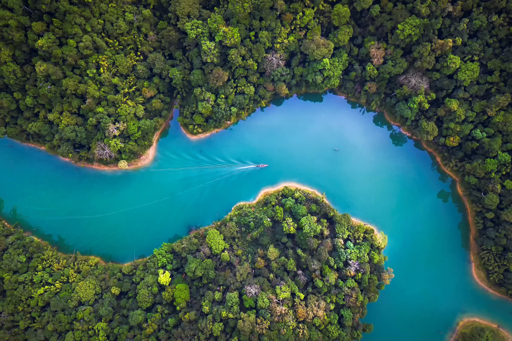

In [5]:
image_name = 'stream1'
raw_image = Image.open("images/" + image_name + ".jpg")
resized_image = resize_image(raw_image, input_size=512)
# Save the resized image
image_path_resized = "images/" + image_name + "_resized.jpg"
resized_image.save(image_path_resized)
resized_image

In [6]:
# What you want to identify in the image
text_prompt = "river"

output = detector(
    resized_image,
    candidate_labels = [text_prompt]
)
# Print the output to identify the bounding boxes detected
print(len(output))
print(output)

thr = 0.16
filtered_output = [entry for entry in output if entry['score'] > thr]
filtered_output

5
[{'score': 0.21514977514743805, 'label': 'river', 'box': {'xmin': 0, 'ymin': 0, 'xmax': 512, 'ymax': 340}}, {'score': 0.15776854753494263, 'label': 'river', 'box': {'xmin': 255, 'ymin': 163, 'xmax': 268, 'ymax': 167}}, {'score': 0.14574529230594635, 'label': 'river', 'box': {'xmin': 0, 'ymin': 86, 'xmax': 511, 'ymax': 340}}, {'score': 0.12235137820243835, 'label': 'river', 'box': {'xmin': 234, 'ymin': 163, 'xmax': 268, 'ymax': 169}}, {'score': 0.11218104511499405, 'label': 'river', 'box': {'xmin': 0, 'ymin': 0, 'xmax': 511, 'ymax': 171}}]


[{'score': 0.21514977514743805,
  'label': 'river',
  'box': {'xmin': 0, 'ymin': 0, 'xmax': 512, 'ymax': 340}}]

### Use the model

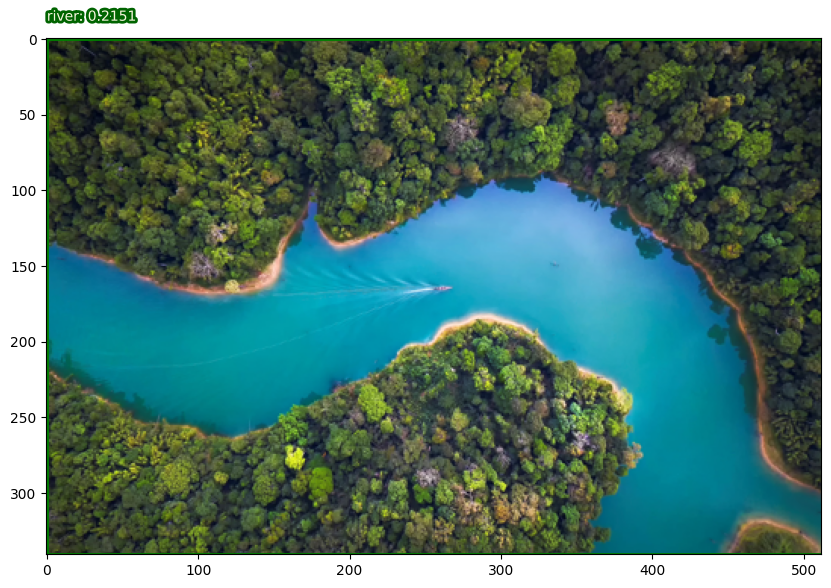

In [7]:
input_scores, input_labels, input_boxes = preprocess_outputs(filtered_output)
# Show the image with the bounding boxes
show_boxes_and_labels_on_image(
    resized_image,
    input_boxes[0],
    input_labels,
    input_scores
)

In [8]:

# Create a list of positive labels of same length as the number of predictions generated above
labels = np.repeat(1, len(filtered_output))
labels

array([1])

In [9]:
result = model.predict(
    resized_image,
    bboxes=input_boxes[0],
    labels=labels
)
result

0: 1024x1024 1 0, 3142.4ms
Speed: 9.6ms preprocess, 3142.4ms inference, 22.3ms postprocess per image at shape (1, 3, 1024, 1024)


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: ultralytics.engine.results.Masks object
 names: {0: '0'}
 obb: None
 orig_img: array([[[ 28,  22,  18],
         [ 36,  45,  39],
         [ 36,  59,  48],
         ...,
         [ 42,  41,  37],
         [ 42,  50,  43],
         [ 43,  63,  51]],
 
        [[ 21,   9,   6],
         [ 32,  35,  29],
         [ 34,  60,  48],
         ...,
         [ 37,  37,  33],
         [ 40,  49,  41],
         [ 39,  58,  46]],
 
        [[ 19,  11,   8],
         [ 27,  27,  21],
         [ 37,  63,  52],
         ...,
         [ 40,  43,  36],
         [ 34,  45,  38],
         [ 31,  48,  39]],
 
        ...,
 
        [[ 33,  56,  52],
         [ 31,  55,  50],
         [ 41,  65,  60],
         ...,
         [ 77, 105, 136],
         [ 98, 128, 161],
         [ 94, 126, 141]],
 
        [[ 37,  59,  55],
         [ 48,  69,  66],
         [ 36,  58,  54],
  

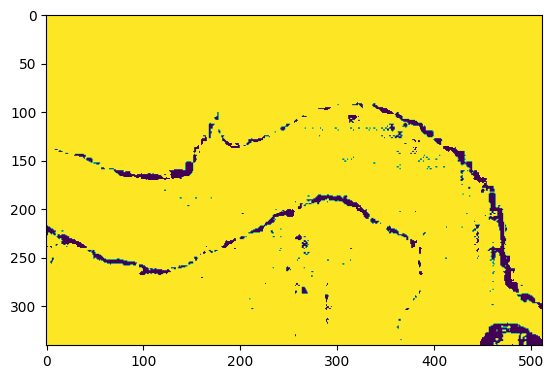

In [10]:
masks = result[0].masks.data
for mask in masks:
    plt.imshow(mask)

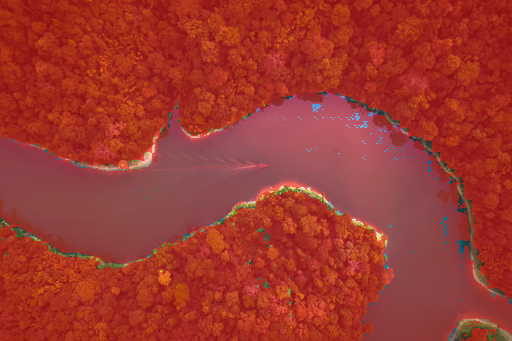

In [11]:
# Visualize the masks
show_masks_on_image(
    resized_image,
    masks
)

In [ ]:
# import time
# # Run multiple models for the same image
# for SAM_version in versions:
#     print(f"Running SAM version: {SAM_version}")
#     t = time.time()
#     model = SAM(model=get_model(SAM_version))  # Specify the model path directly
#     result = model.predict(
#         resized_image,
#         bboxes=input_boxes[0],
#         labels=labels
#     )
#     masks = result[0].masks.data
#     for mask in masks:
#         plt.imshow(mask)
#     print(f"Time taken for {SAM_version}: {time.time() - t:.2f} seconds")
# plt.show()

## Blur Face

In [13]:
candidate_labels = ["human face"]
# Define a new Comet experiment for this new pipeline
exp = comet_ml.Experiment()
# Log image to the experiment
_ = exp.log_image(
    resized_image,
    name = "Raw image"
)

# Apply detector model to the image
output = detector(
    resized_image,
    candidate_labels=candidate_labels
)

input_scores, input_labels, input_boxes = preprocess_outputs(output)
input_boxes

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : symbolic_limestone_5230
COMET INFO:     url                   : https://www.comet.com/brave-mole-718/3-detector-sam/ea8deb2f385e432d90b73fe3361c89f6
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git metadata                 : 1
COMET INFO:     git-patch (uncompressed)     : 1 (7.80 MB)
COMET INFO:     installed packages           : 1
COMET INFO:     notebook                     : 1
COMET INFO:     os packages        

[[[0, 0, 512, 340],
  [0, 87, 511, 340],
  [255, 163, 268, 168],
  [234, 163, 268, 169],
  [0, 101, 269, 263],
  [0, 87, 465, 267]]]

In [14]:
metadata = {
    "prompt": candidate_labels,
    "SAM version": SAM_version,
    "Obj Detector": obj_det_model
}
annotations = make_bbox_annots(
    input_scores,
    input_labels,
    input_boxes,
    metadata
)
_ = exp.log_image(
    raw_image,
    annotations= annotations,
    metadata=metadata,
    name= "OWL output"
)
result = model.predict(
    image_path_resized,
    bboxes=input_boxes[0],
    labels=np.repeat(1, len(input_boxes[0]))
)


image 1/1 /home/sdjkhosh/Projects/Prompt-Engineering-for-Vision-Models/images/stream1_resized.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 14799.5ms
Speed: 23.2ms preprocess, 14799.5ms inference, 3.4ms postprocess per image at shape (1, 3, 1024, 1024)


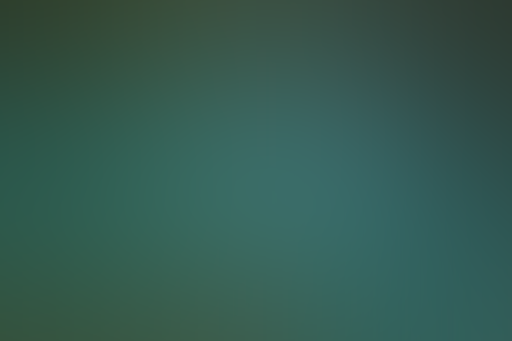

In [15]:
blurred_img = resized_image.filter(GaussianBlur(radius=100))
blurred_img

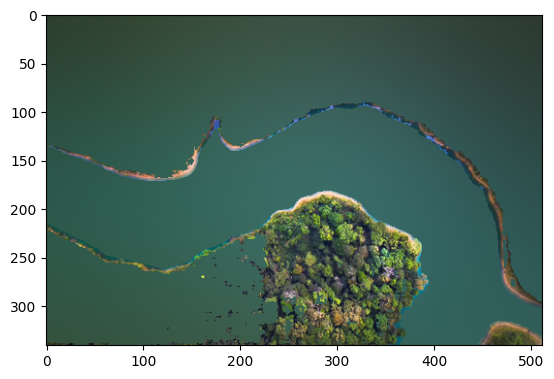

In [16]:
masks = result[0].masks.data.cpu().numpy()
# Create an array of zeroes of the same shape as our image mask
total_mask = np.zeros(masks[0].shape)
# Add each output mask to the total_mask
for mask in masks:
    total_mask = np.add(total_mask,mask)

# Where there is any value other than zero (where any masks exist), show the blurred image
# Else, show the original (unblurred) image
output = np.where(
    np.expand_dims(total_mask != 0, axis=2),
    blurred_img,
    resized_image
)
plt.imshow(output)

In [17]:
metadata = {
    "OWL prompt": candidate_labels,
    "SAM version": SAM_version,
    "OWL version": obj_det_model
}
_ = exp.log_image(
    output,
    name="Blurred masks",
    metadata = metadata,
    annotations=None
)
